---
title: Running Jupyter in a Docker container using pre-made images  
date: 2020-10-05    
comments: false  
tags: docker, machine learning  
keywords: python, data science, docker, jupyter, gradient boosting classifier, machine learning, sklearn

---

While I have been using virtualenvs for dependency management in Python for years, I have put off learning how to use Docker containers until quite recently. It turns out that I should have made the switch sooner! Containers are relatively easy to learn, straightforward to manage and use, and have a number of advantages of working directly on your local machine.

In this blog post and the next, I want to focus on working with Jupyter notebooks within Docker containers, and some of the tips and tricks you can use to make this easier. In this blog post, I'll be focusing on using the pre-made images for data science available on Docker Hub, and in the next post we'll look at how to develop your own image customised for your needs.

## Why use Jupyter within a Docker container?

When starting a new data science project, or indeed, picking up an old one, it's common to have issues with your environment or dependencies. For example, you might have an older version of Python installed, but the package you want to use only works with 3.8. Or you might need an older version of Tensorflow than the one your have globally installed to follow a tutorial. Or you might want to pick up an old analysis you did in R, but its not installed on your machine anymore. Docker containers offer a solution to elegantly handle all of these issues, without the need to install versions on your machine that might clash, or which you might only need for a single project.

[A Docker container](https://www.docker.com/resources/what-container) is essentially a self-contained process that sits on top of your operating system, and which is isolated from all other processes and directories on your computer (unless you specifically open up access points in the container). Due to this separation, you can install programming languages in the container that you don't want installed globally, or you can also install versions of a language that are different to your system version. You can install dependencies that are isolated to the container. You can even create files that only the container can access. 

This means that if you are working with a Jupyter notebook within a container, you can install the language (and version of that language) that you need, along with all of the dependencies, without creating conflicts on your computer. Once you're finished the analysis, you can just shutdown the container, freeing up all of the space taken up by the installations and files that were in the container. This creates a much neater end to analyses as well, where you only keep those files you need, rather than having folders full of the interim files and datasets you created on the way.

Finally, the fact that containers are self-contained make them very helpful for dependency management, making it much easier to do everything from share your analyses to deploying models. Another person (or server) can easily build a container using your image and run your notebooks or application using the same environment that you did.

So with all of these advantages I've described, I hope you're keen to try out using Jupyter in a Docker container yourself!


## Using a pre-made image from Docker Hub

In order to get started with containers, we need to source an [image](https://www.tutorialspoint.com/docker/docker_images.htm) that has all of our required dependencies and can launch a Jupyter notebook instance. (If you've never used Docker containers before, I'd recommend getting acquainted with the basic commands using [this guide](https://docker-curriculum.com/) (or something similar).) The easiest way to get started with this is using one of the [official Jupyter images](https://jupyter-docker-stacks.readthedocs.io/en/latest/), which come in a variety of flavours to fulfill different purposes. 

To get started, let's say that we want to use a [gradient boosting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) to predict survival using [the Titanic dataset](https://www.kaggle.com/c/titanic). Looking through the list of Jupyter images available, it seems that the [jupyter/scipy-notebook](https://jupyter-docker-stacks.readthedocs.io/en/latest/using/selecting.html#jupyter-scipy-notebook) would be the most suitable for this analysis, so let's go ahead and run it from the latest image. If we execute the following in a shell:

In [ ]:
docker run -p 8888:8888 jupyter/scipy-notebook:latest

then we'll be given output that includes the following:

```
To access the notebook, open this file in a browser:
        file:///home/jovyan/.local/share/jupyter/runtime/nbserver-6-open.html
    Or copy and paste one of these URLs:
        http://f5504e8e5c41:8888/?token=XXXXXXXX
     or http://127.0.0.1:8888/?token=XXXXXXX
```

We can then copy and paste our localhost URL (the one starting the `http://127.0.0.1:8888/`) into the browser, and we're connected to our Jupyter notebook in the container!

Before we get into the notebook through, I just wanted to briefly discuss [why we include the `-p 8888:8888` argument as part of running our container](https://medium.com/better-programming/how-does-docker-port-binding-work-b089f23ca4c8). Essentially this container has exposed port 8888; however, in order to be able to connect to the container and work within it we need to bind this port to a corresponding port on our local machine. We therefore include this `-p` (port) argument to tell Docker to bind its internal port with port 8888 on our machine. Without this argument we essentially would have a container running, but no way to access it!

Getting back to our notebook instance, we can see we have an empty directory, with no way to access any files on our computer. This is a part of the isolation of Docker: by default, it cannot read or write locally. One option we have in this case is uploading the data we need manually by dragging and dropping it into our notebook session: 

<img src="/figure/docker-1.png" title="Uploading manually to a Docker notebook instance" style="display: block; margin: auto;" />

To get started, we can create a new Python 3 notebook as usual. Once in the notebook, we can check what version of Python we're running, as well as what libraries we have installed.

In [9]:
!python --version

Python 3.8.3


In [10]:
!pip list

Package                Version
---------------------- -------------------
alembic                1.4.2
async-generator        1.10
attrs                  19.3.0
backcall               0.2.0
beautifulsoup4         4.9.1
bleach                 3.1.5
blinker                1.4
bokeh                  2.0.2
Bottleneck             1.3.2
brotlipy               0.7.0
certifi                2020.6.20
certipy                0.1.3
cffi                   1.14.0
chardet                3.0.4
click                  7.1.2
cloudpickle            1.4.1
conda                  4.8.3
conda-package-handling 1.6.0
cryptography           2.9.2
cycler                 0.10.0
Cython                 0.29.21
cytoolz                0.10.1
dask                   2.15.0
decorator              4.4.2
defusedxml             0.6.0
dill                   0.3.2
distributed            2.20.0
entrypoints            0.3
fastcache              1.1.0
fsspec                 0.7.4
gmpy2                  2.1.0b1
h5py              

You can see that the notebook is running on the extremely current Python 3.8.3, and has pretty much everything we could need for a Scipy-based analysis installed. If you want a specific image, rather than the latest one (for reproducibility, for instance), you can also specify a release from [this list](https://hub.docker.com/r/jupyter/scipy-notebook/tags/).

## Running a model 

We're now ready to start our analysis. In order to keep this blog post a bit more focused, I have already preprocessed the Titanic training data, keeping the `Pclass`, `Sex`, `Age`, `SibSp`, `Parch` and `Fare` features, and running some light data cleaning such as replacing missing data and converting age to a numeric variable. I also separated the outcome (`Survived`) from the features, saving them as `X_data` and `y_data`. Let's start by importing our dependencies and reading in the data. We will also split the data into training and validation sets using `sklearn`'s `train_test_split` method.

In [2]:
import os

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV

data_path = os.getcwd()
X_data = np.load(os.path.join(data_path, "X_data.npy"))
y_data = np.load(os.path.join(data_path, "y_data.npy"))

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=123)

You can see that out of the box, this image contains everything we need for this analysis, and we've been able to get started without any friction or backtracking. Let's see how we go with running a grid search to get some hyperparameter values. For the sake of time, I am only tuning the values of `max_depth` and `max_features`.

In [5]:
gb = GradientBoostingClassifier()

max_depth = [2, 3, 4, 5, 6, 7]
max_features = [2, 3, 4, 5]

param_grid = dict(max_depth = max_depth, max_features = max_features)
grid = GridSearchCV(estimator=gb, param_grid=param_grid, scoring = "accuracy", )

grid.fit(X_train, y_train)

print("BEST MODEL ACCURACY")
print(grid.best_score_)
print("\nBEST HYPERPARAMETER VALUES")
print(f"Max depth: {grid.best_estimator_.max_depth}")
print(f"Max features: {grid.best_estimator_.max_features}")

BEST MODEL ACCURACY
0.8263831219840647

BEST HYPERPARAMETER VALUES
Max depth: 3
Max features: 2


We can now use these values to build our model and get our performance metrics:

In [6]:
gb_tuned = GradientBoostingClassifier(max_depth=3, max_features=2)
gb_tuned.fit(X_train, y_train)
predictions = gb_tuned.predict(X_val)

print("Classification Report")
print(classification_report(y_val, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       139
           1       0.81      0.71      0.76        84

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.83      0.83      0.83       223



Finally, we can also display charts as per usual in these Jupyter notebooks. As we know we have `matplotlib` and `seaborn` installed, let's go ahead and visualise our confusion matrix:

In [7]:
def print_confusion_matrix(
    confusion_matrix: "numpy.ndarray",
    class_names: list,
    normalize: bool = False,
    figsize: tuple = (10, 7),
    fontsize: int = 14):

    """
    Reads in an sklearn confusion matrix and returns a plot. Code taken from: 
    https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    """

    if normalize:
        confusion_matrix = (
            confusion_matrix.astype("float")
            / confusion_matrix.sum(axis=1)[:, np.newaxis]
        )
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(
            df_cm, cmap="RdBu", annot=True, fmt=".2f" if normalize else "d"
        )
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0, ha="right", fontsize=fontsize
    )
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=45, ha="right", fontsize=fontsize
    )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Normalized confusion matrix


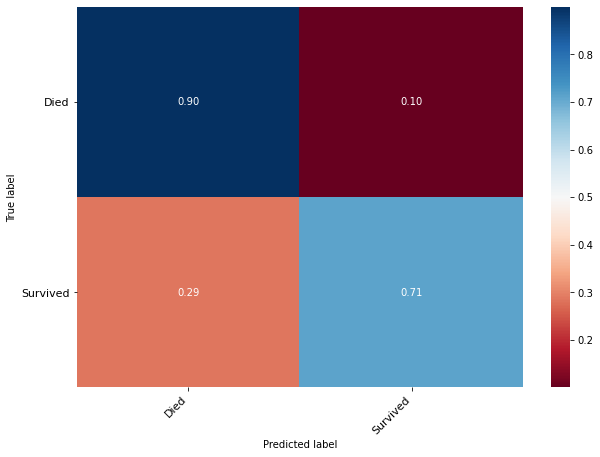

In [8]:
%matplotlib inline
survived_cm = confusion_matrix(y_val, predictions)
print_confusion_matrix(
    survived_cm,
    ["Died", "Survived"],
    normalize=True,
    fontsize=11,
)

## Mounting a volume

As I said earlier, any notebooks, datasets, or other files that we create during this session will be destroyed when the notebook is shutdown. In this case, you will need to download those files you want to keep at the end of your session. This might be advantageous (for instance, you might want to have a tidy analysis file with just those notebooks and datasets you ended up needing), but there are times you might want to have access to a local directory to load and save files instead. In this case, we can mount a volume when we run our container. This argument has two parts: the directory on your computer you want to mount, and the internal directory within your container. This container directory is defined as part of the image, and we'll discuss it more in the next blog post. For now, all you need to understand is that for the official Jupyter images it is `/home/jovyan/work`. Hence, to mount my local directory `~/Documents/gbc-titanic` to the container, I add the argument `-v ~/Documents/gbc-titanic:/home/jovyan/work` to my run command, as so:

In [ ]:
docker run -p 8888:8888 -v ~/Documents/gbc-titanic:/home/jovyan/work jupyter/scipy-notebook:latest

When you enter the notebook instance in your container, you'll now see you have access to this directory within the `work` directory. You can now read and write files within this directory, and anything made within the container will be saved locally.

That is all for this post, but stay tuned for the next one where I teach you how to create your own image, including creating images for different versions of Python and how to use the image to copy over files to your container rather than doing it manually.